# Gompertz-based GBR coral resilience

To address the question of hard coral resilience requires some sort of mechanistic model, where impacts that deplete coral are followed by a period of recovery. To do this we use a modification of the Gompertz-based model of [Fukuya et al.](http://onlinelibrary.wiley.com/doi/10.1111/j.1365-2656.2010.01727.x/full), which is an appropriate coverage-based population model for sessile invertebrates.

### Data wrangling

First we can import the data, which consist of hard coral estimates from [AIMS Long Term Monitoring Program](http://www.aims.gov.au/docs/research/monitoring/reef/latest-surveys.html), as well as corresponding disturbances that have led to coral decline. 

In [1]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano as T
import matplotlib as mp
import theano.tensor as tt
import seaborn as sns
import scipy as sp
import pdb

In [2]:
# Helper functions
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: np.array([ b.index(x) if x in b else None for x in a ])
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(2*np.std(x))

In [3]:
# Import ltmp data
xdata = pd.read_csv('GBR_ltmp.csv')

In [4]:
# Set reefyear
reefyear = np.array([r+str(y) for r,y in zip(xdata.REEF_NAME.values,xdata.REPORT_YEAR.values)])
# Create new cluster code column
xdata['ClustCode'] = xdata.CLUSTER.values
# Substitute ClusterNames for Cluster codes
Clust_dict = ['CL1','CL2','CL3','CL4']
Clust_names = np.array(['Porities-A','Mixed','Soft-coral','Acropora'])
xdata['CLUSTER'] = np.array(Clust_names)[match(xdata.ClustCode.values,Clust_dict)]
xdata['reefNyear'] = xdata.REEF_NAME+'_'+xdata.REPORT_YEAR.astype(str)
xdata['ShelfCluster'] = xdata.SHELF+'_'+xdata.ClustCode

In [5]:
xdata.columns

Index(['REEF_ID', 'REEF_NAME', 'A_SECTOR', 'SHELF', 'LAT', 'LON', 'SITE_LAT',
       'SITE_LON', 'SITE_NO', 'TRANSECT_NO', 'REPORT_YEAR', 'COVER',
       'DISTURBANCE', 'COTS', 'STORM', 'BLEACHING', 'DISEASE', 'C', 'S', 'B',
       'D', 'BENT_CLUST', 'CLUSTER', 'CONNECTEDNESS', 'AREA', 'RST', 'RSTY',
       'HC', 'HC_1', 'HERB', 'HERB2', 'iZONE', 'sZONE', 'PFp', 'PFs', 'PFt',
       'PFsum', 'ClustCode', 'reefNyear', 'ShelfCluster'],
      dtype='object')

In [6]:
# Get rid of missing years
xdata = xdata.loc[xdata.HC > 0]
xdata = xdata.loc[xdata.HC_1 > 0]
np.shape(xdata)

(8487, 40)

Grab covariates

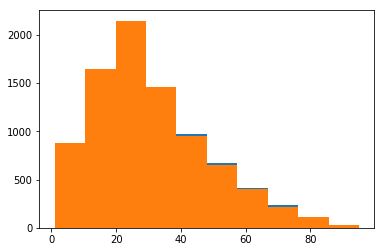

In [7]:
# Hard coral - out of 200 points
HC = np.round(xdata.HC.values)+1
nobs = len(HC)
plt.hist(HC)

# Lag-1 hard coral
HC1 = np.round(xdata.HC_1.values)+1
plt.hist(HC1)

# log lag-1 hard coral
lHC = np.log(HC)
lHC1 = np.log(HC1)

# Number of observations
nobs = len(lHC1)

Grab covariates

In [8]:
# Make missing disturbances 'Unknown'
Dist_ = xdata.DISTURBANCE.values
Dist_[Dist_=='-999'] = 'U'
# Create unknown disturbance array
UNK = (Dist_=='U')*1

# CoTS outbreaks
CoTS = stdize(np.log(xdata.C.values+1))

# Cyclones
STORM = stdize(np.log(xdata.S.values+1))

# Bleaching
BLEACH = stdize(np.log(xdata.B.values+1))

# Disease
DISEASE = stdize(np.log(xdata.D.values+1))

# log-Herbivory
tmp = xdata.HERB.values
tmp[tmp==-999] = np.mean(tmp[tmp!=-999])
HERB = stdize(np.log(tmp+1))

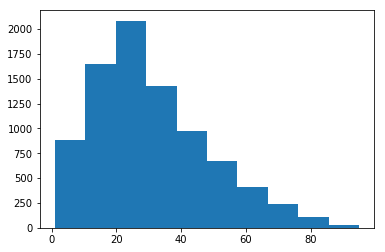

In [9]:
plt.hist(HC);

The next step is to sort out the indexing so that parameters can be estimated hierarchially

In [10]:
# Index each reef to a given cluster
Cluster,Ic = subindexall(xdata.CLUSTER.values,xdata.REEF_NAME.values)
ncluster = len(Cluster)

# Index each transect to a given reef
Reef,Ir = indexall(xdata.REEF_NAME.values)
nreefs = len(Reef)

# Index each transect to a given cluster
Cluster_t,Ict = indexall(xdata.CLUSTER.values)
nct = len(Cluster_t)

In [11]:
# Year
year = xdata.REPORT_YEAR.values
nyears = len(np.unique(year))
YR = xdata.REPORT_YEAR.values-1995
maxyr = max(YR)

In [12]:
# Disturbance array
DIST = ['CoTS','Cyclones','Bleaching','Disease','Unknown']

In [13]:
# Index constant reef-scale covariates
rindx = np.array([list(xdata.REEF_NAME.values).index(x) for x in Reef])

# Get water quality values
WQ = xdata.PFsum.values[rindx]
# Mean water quality per cluster
Mean_wq = np.array([np.mean(WQ[Ic==i]) for i in range(ncluster)])
# Zero-centred water quality per cluster
ZcWQ = WQ-Mean_wq[Ic]

# Get zoning for resistance
ZONE = (xdata.iZONE.values+xdata.sZONE.values>0)*1
# Get zoning values for recovery
rZONE = ZONE[rindx]

# Get shelf position for each reef
Shelf,Is = indexall(xdata.SHELF.values)
nshelf = len(Shelf)

## Bayesian HLM

In [14]:
Model = pm.Model()

# Gompertz-based dynamics model
with Model:
    # Cluster-specific rate of increase
    r_Cluster = pm.Normal('r_Cluster', mu=1.2, sd=100, shape=ncluster)
    # Cluster-specific density dependene
    a_Cluster = pm.Normal('a_Cluster', mu=0.3, sd=100, shape=ncluster)
    
    # Within-cluster variation
    sigma_r = pm.Uniform('sigma_r', lower=0, upper=100, shape=ncluster)
    sigma_a = pm.Uniform('sigma_a', lower=0, upper=100, shape=ncluster)

    # Effect of zoning on recovery rate
    k0 = pm.Normal('Zone', mu=0.0, tau=0.001)
    # Effect of water quality on recovery rate
    e0 = pm.Normal('WQ', mu=0.0, tau=0.001)
    
    # Reef recovery rate model
    mu_r_reef = r_Cluster[Ic]+k0*rZONE+e0*WQ
    r_Reef = pm.Normal('r_Reef', mu=mu_r_reef, sd=sigma_r[Ic], shape=nreefs)
    
    # Reef density-dependent parameter intercepts
    a_Reef = pm.Normal('a_Reef', mu=a_Cluster[Ic], sd=sigma_a[Ic], shape=nreefs)
    
    # Direct disturbance effects on hard coral cover
    k2 = pm.Normal('CoTS', mu=0.0, sd=100)
    s2 = pm.Uniform('SD_CoTS', lower=0.001, upper=100)
    g2 = pm.Normal('cots_', mu=k2, sd=s2, shape=ncluster)
    k3 = pm.Normal('Storms', mu=0.0, sd=100)
    s3 = pm.Uniform('SD_Storms', lower=0.001, upper=100)
    g3 = pm.Normal('Cyclones', mu=k3, sd=s3, shape=nshelf)
    g4 = pm.Normal('Bleaching', mu=0.0, sd=100)
    g5 = pm.Normal('Disease', mu=0.0, sd=100)
    g6 = pm.Normal('Unknown', mu=0.0, sd=100)
    
    # Effect of herbivory on recovery rate
    g7 = pm.Normal('Herbivory', mu=0.0, sd=100)
    
    # Water quality interactions with disturbance
    g8 = pm.Normal('WQ_bleach', mu=0.0, sd=100)
    g9 = pm.Normal('WQ_CoTS', mu=0.0, sd=100)
    g10 = pm.Normal('WQ_Disease', mu=0.0, sd=100)
    g11 = pm.Normal('WQ_Unknown', mu=0.0, sd=100)
    
    # Zoning interactions with disturbance
    g12 = pm.Normal('Z_bleach', mu=0.0, sd=100)
    g13 = pm.Normal('Z_CoTS', mu=0.0, sd=100)
    g14 = pm.Normal('Z_Disease', mu=0.0, sd=100)
    g15 = pm.Normal('Z_Unknown', mu=0.0, sd=100)
    
    # Transect-level model
    mu = (r_Reef[Ir]+g7*HERB)+(1.-a_Reef[Ir])*lHC1+g2[Ict]*CoTS+g3[Is]*STORM+g4*BLEACH+g5*DISEASE+g6*UNK+g8*BLEACH*WQ[Ir]+g9*CoTS*WQ[Ir]+g10*DISEASE*WQ[Ir]+g11*UNK*WQ[Ir]+g12*BLEACH*ZONE+g13*CoTS*ZONE+g14*DISEASE*ZONE+g15*UNK*ZONE
    
    # Link function
    logmu = tt.exp(mu)/100.
    
    # Likelihood
    Yi = pm.Binomial('Yi', n=100, p=logmu, observed=HC)

In [15]:
# Sampling
with Model:
    # Draw samples using NUTS
    trace = pm.sample(5000, init=None,  njobs=3)

Multiprocess sampling (3 chains in 3 jobs)
NUTS: [Z_Unknown, Z_Disease, Z_CoTS, Z_bleach, WQ_Unknown, WQ_Disease, WQ_CoTS, WQ_bleach, Herbivory, Unknown, Disease, Bleaching, Cyclones, SD_Storms, Storms, cots_, SD_CoTS, CoTS, a_Reef, r_Reef, WQ, Zone, sigma_a, sigma_r, a_Cluster, r_Cluster]
Sampling 3 chains: 100%|██████████| 16500/16500 [16:46<00:00,  6.12draws/s]
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [16]:
pm.stats.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
r_Cluster__0,1.118751,0.183480,0.002042,0.734466,1.460115,6576.522838,1.000095
r_Cluster__1,1.082617,0.174407,0.001532,0.758051,1.452460,12100.125742,0.999920
r_Cluster__2,1.480098,0.196469,0.001732,1.084201,1.863661,11809.927324,0.999936
r_Cluster__3,1.049608,0.128215,0.001033,0.783642,1.292311,14410.816636,0.999934
a_Cluster__0,0.250172,0.043628,0.000339,0.166953,0.341950,13458.228587,0.999908
a_Cluster__1,0.257030,0.036438,0.000265,0.187045,0.332365,16023.558555,0.999946
a_Cluster__2,0.355328,0.042368,0.000366,0.273419,0.444176,13226.507461,0.999982
a_Cluster__3,0.301054,0.035068,0.000258,0.232209,0.370155,16844.892537,0.999909
Zone,-0.079065,0.118307,0.001222,-0.306030,0.166030,10252.434838,0.999974
WQ,-0.695239,0.271604,0.002868,-1.177384,-0.092351,7358.764477,0.999991


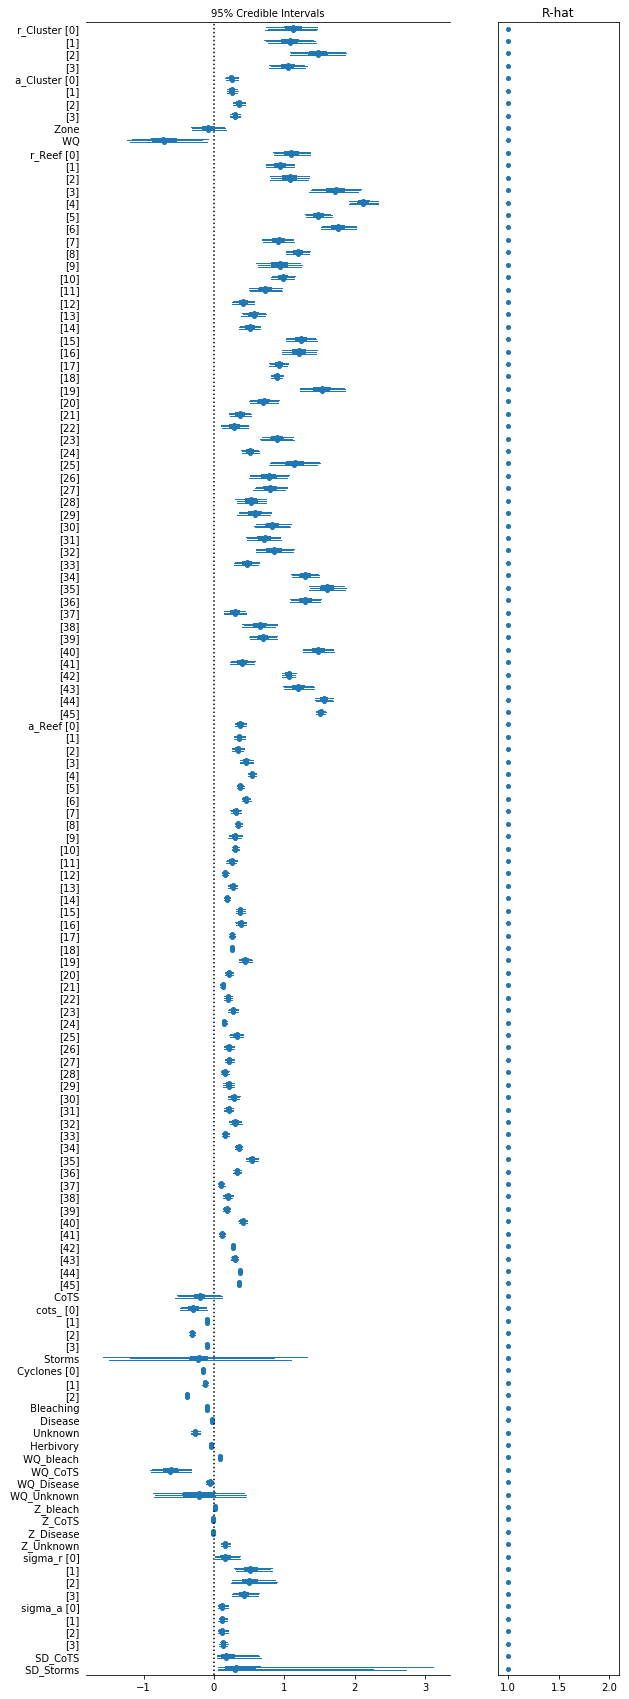

In [17]:
fig = plt.figure(figsize=(10, 27))
pm.forestplot(trace, rhat=True)
fig.savefig('Figure_S1.pdf');

<Figure size 432x288 with 0 Axes>

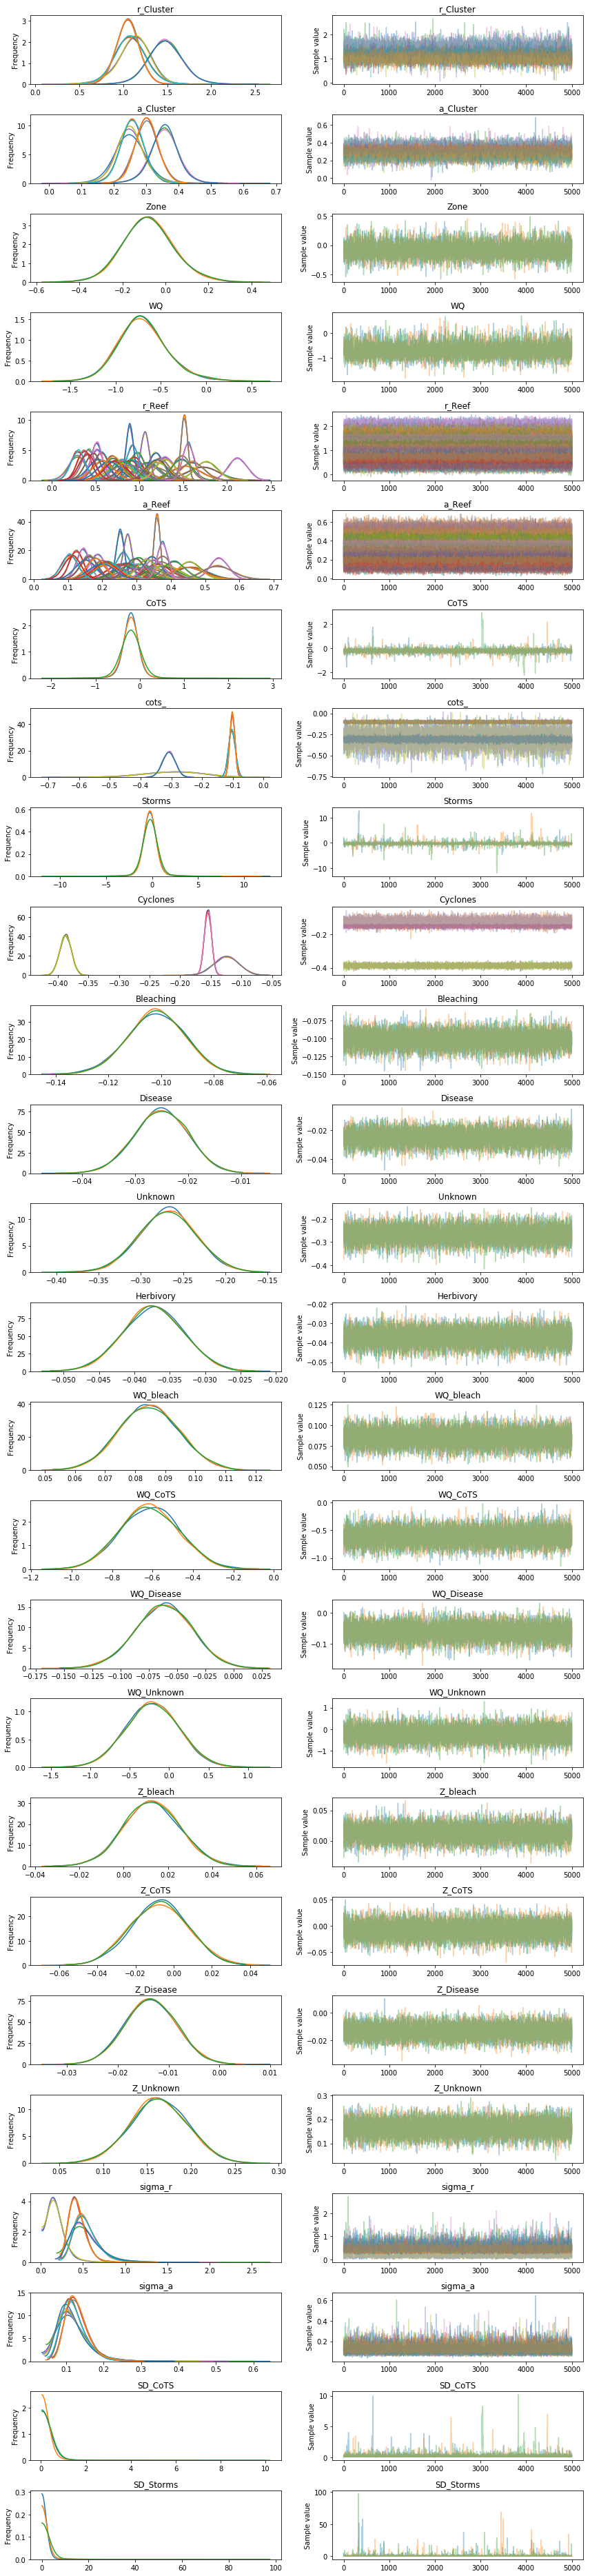

In [32]:
fig = plt.figure()
pm.traceplot(trace)
fig.savefig('Figure_S2.jpg');

In [19]:
ppc = pm.sample_ppc(trace, model=Model)

/Users/aaronmacneil/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
100%|██████████| 15000/15000 [01:01<00:00, 245.11it/s]


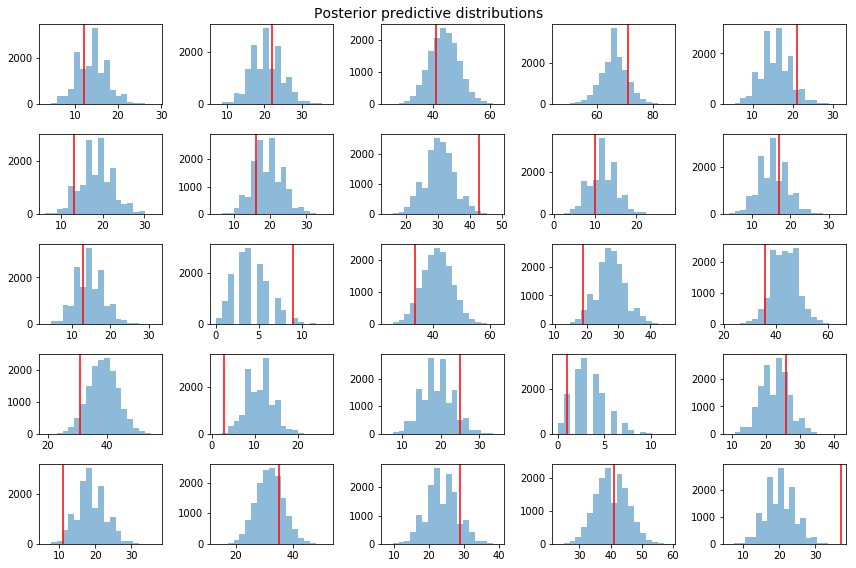

In [20]:
# Setup multipanel figure
nrows, ncols = 5, 5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,8))
ax_ = axes.flatten()

# Transform ppc
PPC = ppc['Yi'].T
# Index random observations
indx = np.random.randint(0,len(PPC),size=nrows*ncols)

# Iterate over random samples from ppc
for i in range(nrows*ncols):
    ax1 = ax_[i]
    ax1.hist(PPC[indx[i]], bins=19, alpha=0.5)
    ax1.axvline(HC[indx[i]],c='red')

fig.tight_layout()
fig.suptitle('Posterior predictive distributions', fontsize=14)
fig.subplots_adjust(top=0.95)
plt.savefig('Figure_S3.pdf');

In [21]:
# Expected HC values
EHC = np.exp((np.median(trace['r_Reef'],axis=0)[Ir]+np.median(trace['Herbivory'])*HERB)+(1.-np.median(trace['a_Reef'],axis=0)[Ir])*lHC1+np.median(trace['CoTS'],axis=0)*CoTS+np.median(trace['Storms'])*STORM+np.median(trace['Bleaching'])*BLEACH+np.median(trace['Disease'])*DISEASE+np.median(trace['Unknown'])*UNK+np.median(trace['WQ_bleach'])*BLEACH*WQ[Ir]+np.median(trace['WQ_CoTS'])*CoTS*WQ[Ir]+np.median(trace['WQ_Disease'])*DISEASE*WQ[Ir]+np.median(trace['WQ_Unknown'])*UNK*WQ[Ir]+np.median(trace['Z_bleach'])*BLEACH*ZONE+np.median(trace['Z_CoTS'])*CoTS*ZONE+np.median(trace['Z_Disease'])*DISEASE*ZONE+np.median(trace['Z_Unknown'])*UNK*ZONE)

# PPD medians
Yrep = np.median(PPC,axis=1)

In [22]:
# Bayesian p-value
Bpval = (EHC-HC)>(Yrep-HC)
sum(Bpval)/nobs

0.5587368917167432

In [23]:
# Export results 
out = pm.backends.tracetab.trace_to_dataframe(trace)
colnames = np.array(list(out.columns), dtype=object)
# Edit column names
colnames[np.array([list(colnames).index(x) for x in grep('r_Reef',colnames)])] = np.array(['r_'+r for r in Reef])
colnames[np.array([list(colnames).index(x) for x in grep('a_Reef',colnames)])] = np.array(['a_'+r for r in Reef])
colnames[np.array([list(colnames).index(x) for x in grep('r_Cluster',colnames)])] = np.array(['r_'+c for c in Cluster])
colnames[np.array([list(colnames).index(x) for x in grep('a_Cluster',colnames)])] = np.array(['a_'+c for c in Cluster])
colnames[np.array([list(colnames).index(x) for x in grep('cots_',colnames)])] = np.array(['cots_'+c for c in Cluster])
colnames[np.array([list(colnames).index(x) for x in grep('sigma_r',colnames)])] = np.array(['sigma_r_'+c for c in Cluster])
colnames[np.array([list(colnames).index(x) for x in grep('sigma_a',colnames)])] = np.array(['sigma_a_'+c for c in Cluster])
colnames[np.array([list(colnames).index(x) for x in grep('Cyclones',colnames)])] = np.array(['Storm_'+s for s in Shelf])

In [24]:
out.columns = list(colnames)

In [25]:
out.head()

,r_Porities-A,r_Mixed,r_Acropora,r_Soft-coral,a_Porities-A,a_Mixed,a_Acropora,a_Soft-coral,Zone,WQ,...,sigma_r_Porities-A,sigma_r_Mixed,sigma_r_Acropora,sigma_r_Soft-coral,sigma_a_Porities-A,sigma_a_Mixed,sigma_a_Acropora,sigma_a_Soft-coral,SD_CoTS,SD_Storms
0,0.837294,0.984338,1.717749,0.987658,0.212623,0.268052,0.383690,0.366887,-0.231946,-0.155756,...,0.253759,0.414713,0.396231,0.437560,0.173253,0.128692,0.117084,0.159700,0.063719,4.893889
1,1.244881,1.027108,1.523435,1.222157,0.284558,0.275295,0.339918,0.278107,-0.177402,-0.699939,...,0.210190,0.283527,0.405059,0.565226,0.115912,0.100838,0.134626,0.092256,0.174519,4.423283
2,1.022684,1.138868,1.000483,1.111824,0.235850,0.314089,0.290241,0.340978,-0.137109,-0.604025,...,0.064917,0.439543,0.610558,0.497561,0.081500,0.147371,0.207115,0.107201,0.131301,1.848815
3,1.007504,1.056842,0.984567,1.049400,0.249518,0.256106,0.294765,0.279324,-0.166579,-0.559960,...,0.039349,0.359369,0.641842,0.422666,0.111686,0.107531,0.229530,0.074108,0.075616,3.400572
4,1.419140,1.352081,2.221674,1.146254,0.287935,0.278757,0.379177,0.354516,-0.289715,-0.899469,...,0.114216,0.570999,0.624111,0.377121,0.142034,0.112464,0.069028,0.211199,0.120236,1.714010


In [26]:
out.shape

(15000, 133)

In [27]:
out.to_csv('Gompertz_results.csv')